# **Second Project: Developing Machine Learning Model Using Data Time Series**

**Name: Nicko Arya Dharma**   
**Email: nicko.arya.dharma@gmail.com**   
**DicodingID: nickoaryad**  

## **1 <font color='yellow'>**|**</font> About the Dataset**

This dataset includes all the historical data of S&P 500 index from 1927 to 2020 with the date, opening price, highest price, lowest price, closing price, adjusted closing price( after all applicable splits and dividend distributions), and the number of shares traded of the day as columns.

The dataset consists of two columns:   
* Date   
* Opening Price   
* Lowest Price   
* Highest Price   
* Closing Price    
* Adjusting Closing Price   
* Volume    

Source:   
https://www.kaggle.com/code/minhhoangngcyber/energy-consumption-prediction-tensorflow-lstm-rnn/input?select=EKPC_hourly.csv

## **2 <font color='yellow'>**|**</font> Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, date

import warnings
warnings.filterwarnings("ignore")

## **3 <font color='yellow'>**|**</font> Preparing the Dataset**

#### **3.1 <font color='yellow'>**|**</font> Extracting the Dataset**

In [2]:
local_zip = '/SPX.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#### **3.2 <font color='yellow'>**|**</font> Reading the Dataset**

In [3]:
data = pd.read_csv('/tmp/SPX.csv', on_bad_lines='skip', encoding='latin1')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...,...
23318,2020-10-29,3277.169922,3341.050049,3259.820068,3310.110107,3310.110107,4903070000
23319,2020-10-30,3293.590088,3304.929932,3233.939941,3269.959961,3269.959961,4840450000
23320,2020-11-02,3296.199951,3330.139893,3279.739990,3310.239990,3310.239990,4310590000
23321,2020-11-03,3336.250000,3389.489990,3336.250000,3369.159912,3369.159912,4220070000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23323 entries, 0 to 23322
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23323 non-null  object 
 1   Open       23323 non-null  float64
 2   High       23323 non-null  float64
 3   Low        23323 non-null  float64
 4   Close      23323 non-null  float64
 5   Adj Close  23323 non-null  float64
 6   Volume     23323 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB


#### **3.3 <font color='yellow'>**|**</font> Wrangling the Dataset**

In [5]:
# Changing data type
data['Date'] = pd.to_datetime(data['Date'])

# Deleting columns
data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Renaming column
data.columns = ['Date', 'Price']

data

,Date,Price
0,1927-12-30,17.660000
1,1928-01-03,17.760000
2,1928-01-04,17.719999
3,1928-01-05,17.549999
4,1928-01-06,17.660000
...,...,...
23318,2020-10-29,3310.110107
23319,2020-10-30,3269.959961
23320,2020-11-02,3310.239990
23321,2020-11-03,3369.159912


In [6]:
# Inspecting any NaN data
data.isna().sum()

Date     0
Price    0
dtype: int64

In [7]:
# Inspecting any null data
data.isnull().sum()

Date     0
Price    0
dtype: int64

#### **3.4 <font color='yellow'>**|**</font> Plotting the Dataset**

Text(0, 0.5, 'Price')

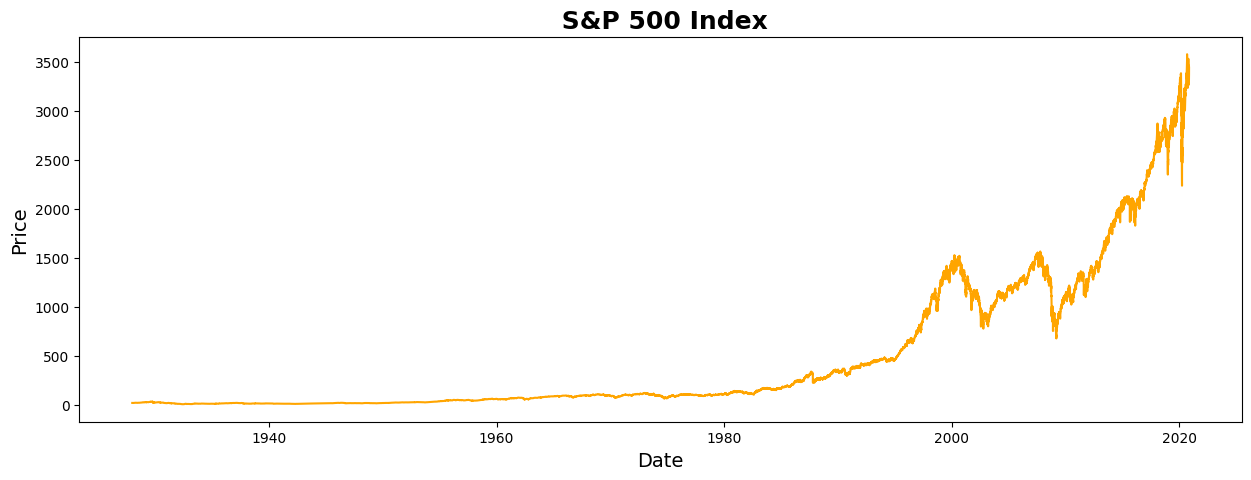

In [8]:
dates = data['Date'].values
loads  = data['Price'].values

plt.figure(figsize=(15,5))
plt.plot(dates, loads, color='orange')
plt.title(' S&P 500 Index', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

## **4 <font color='yellow'>**|**</font> Preprocessing the Dataset**

#### **4.1 <font color='yellow'>**|**</font> Checking Outliers in the Dataset**

<Axes: xlabel='Price', ylabel='Density'>

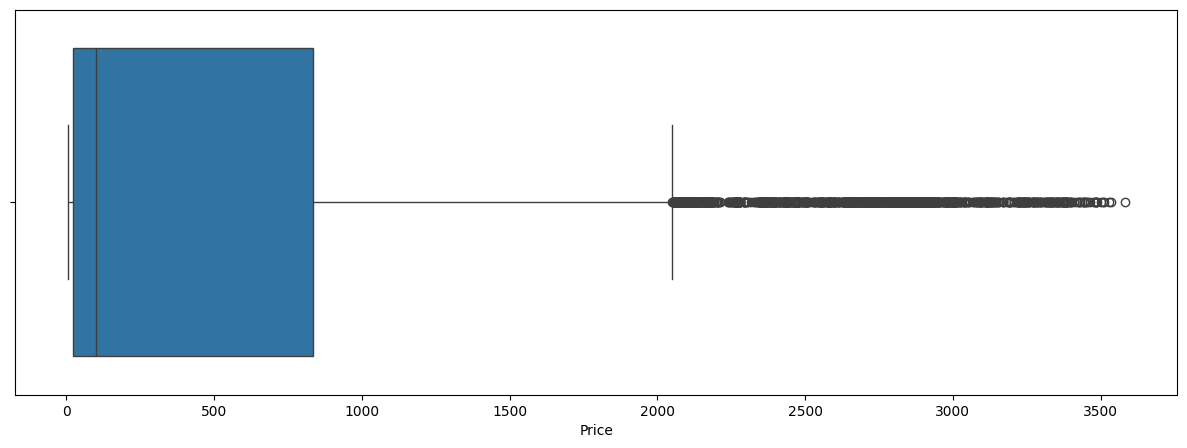

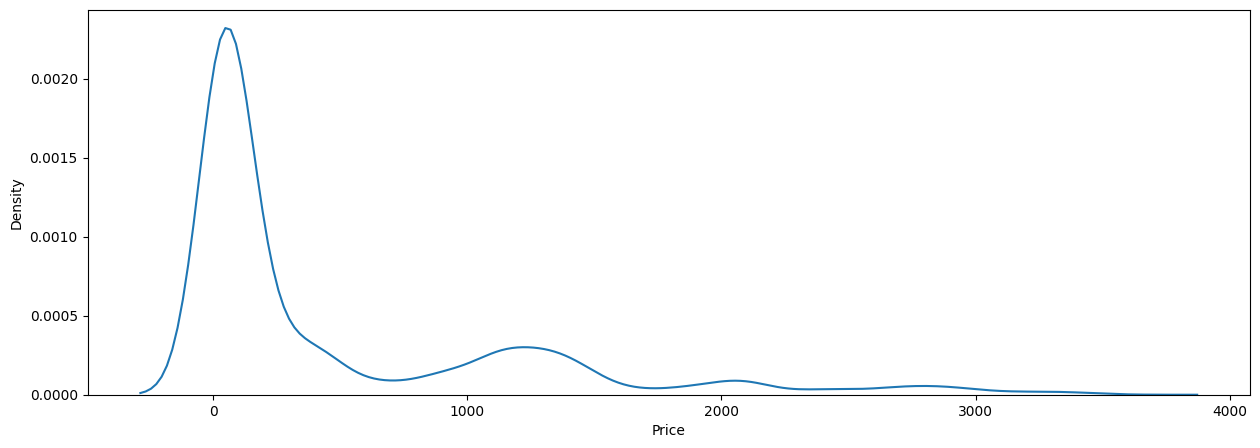

In [9]:
# Checking for any outliers in the dataset
plt.figure(figsize=(15,5))
sns.boxplot(x='Price', data=data)

plt.figure(figsize=(15,5))
sns.kdeplot(x='Price', data=data)

#### **4.2 <font color='yellow'>**|**</font> Removing Outliers from the Dataset**

In [10]:
# Removing outliers using IQR method
def IQR_outliers(data, column):
   Q1 = data['Price'].quantile(.25)
   Q3 = data['Price'].quantile(.75)
   IQR = Q3 - Q1
   data = data.loc[lambda data: ~((data['Price'] < (Q1 - 1.5 * IQR)) | (data['Price'] > (Q3 + 1.5 * IQR)))]
   return data
data = data.pipe(IQR_outliers, 'Price').pipe(IQR_outliers, 'Price')

data

,Date,Price
0,1927-12-30,17.660000
1,1928-01-03,17.760000
2,1928-01-04,17.719999
3,1928-01-05,17.549999
4,1928-01-06,17.660000
...,...,...
20758,2010-08-30,1048.920044
20759,2010-08-31,1049.329956
20760,2010-09-01,1080.290039
20761,2010-09-02,1090.099976


In [11]:
print(f'The dataframe has {data.shape[0]} records')

The dataframe has 19653 records


<Axes: xlabel='Price', ylabel='Density'>

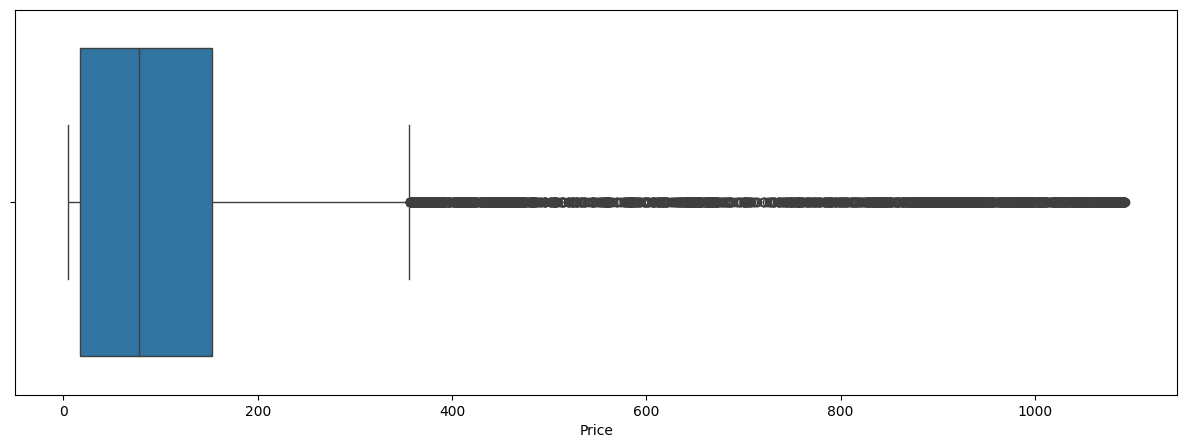

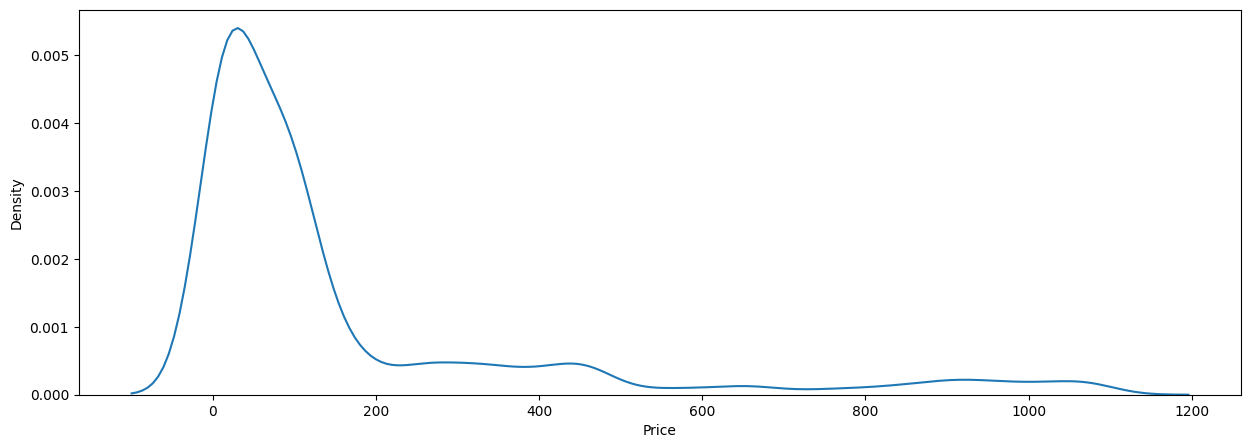

In [11]:
plt.figure(figsize=(15,5))
sns.boxplot(x='Price', data=data)

plt.figure(figsize=(15,5))
sns.kdeplot(x='Price', data=data)

#### **4.4 <font color='yellow'>**|**</font> Normalizing the Dataset**

In [12]:
normalizer = MinMaxScaler()
data['Price'] = normalizer.fit_transform(data['Price'].values.reshape(-1, 1))
data

,Date,Price
0,1927-12-30,0.012189
1,1928-01-03,0.012281
2,1928-01-04,0.012245
3,1928-01-05,0.012088
4,1928-01-06,0.012189
...,...,...
20758,2010-08-30,0.960187
20759,2010-08-31,0.960564
20760,2010-09-01,0.989024
20761,2010-09-02,0.998042


<Axes: xlabel='Price', ylabel='Density'>

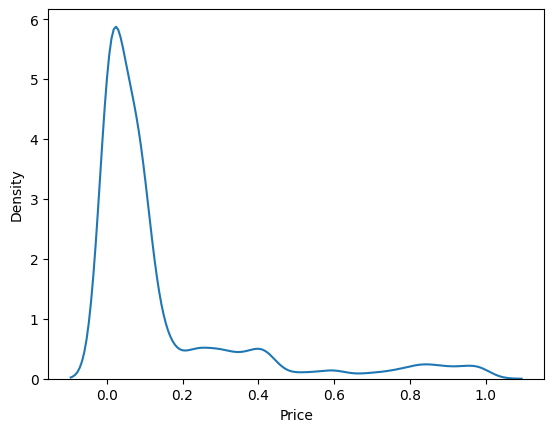

In [13]:
sns.kdeplot(x='Price', data=data)

## **5 <font color='yellow'>**|**</font> Splitting the Dataset**

In [14]:
data_train = data.values
X = data_train[:,0:1] #Atribut
Y = data_train[:,1:2] #Label

In [15]:
X

array([[Timestamp('1927-12-30 00:00:00')],
       [Timestamp('1928-01-03 00:00:00')],
       [Timestamp('1928-01-04 00:00:00')],
       ...,
       [Timestamp('2010-09-01 00:00:00')],
       [Timestamp('2010-09-02 00:00:00')],
       [Timestamp('2010-09-07 00:00:00')]], dtype=object)

In [16]:
Y

array([[0.012189404818572842],
       [0.012281330948426334],
       [0.012244559577223639],
       ...,
       [0.9890240743319098],
       [0.9980419697570755],
       [0.9996414752239131]], dtype=object)

In [17]:
data_train

array([[Timestamp('1927-12-30 00:00:00'), 0.012189404818572842],
       [Timestamp('1928-01-03 00:00:00'), 0.012281330948426334],
       [Timestamp('1928-01-04 00:00:00'), 0.012244559577223639],
       ...,
       [Timestamp('2010-09-01 00:00:00'), 0.9890240743319098],
       [Timestamp('2010-09-02 00:00:00'), 0.9980419697570755],
       [Timestamp('2010-09-07 00:00:00'), 0.9996414752239131]],
      dtype=object)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [19]:
print("Train Set     = ", len(X_train))
print("Test Set      =  ", len(X_test))
print("Total Dataset = ", len(data_train))

Train Set     =  14800
Test Set      =   3701
Total Dataset =  18501


## **6 <font color='yellow'>**|**</font> Developing Model**

#### **6.1 <font color='yellow'>**|**</font> Developing Model Batch**

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
window_size = 60
batch_size = 64
shuffle_buffer = 1000

Y_train = np.asarray(Y_train).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

train_set = windowed_dataset(Y_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
val_set = windowed_dataset(Y_test, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)

In [22]:
max = data['Price'].max()
min = data['Price'].min()

print('Max value         = ', max)

print('Min Value         = ', min)

threshold = (max - min) * (10/100)
print('MAE Threshold     = ', threshold)

Max value         =  1.0
Min Value         =  0.0
MAE Threshold     =  0.1


#### **6.2 <font color='yellow'>**|**</font> Sequential Modelling using LSTM**

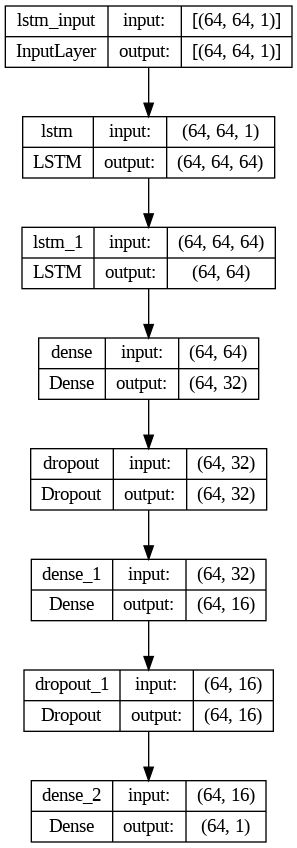

In [23]:
model = Sequential([
  LSTM(units=64, batch_input_shape=(64, 64, 1), return_sequences=True),
  LSTM(64),
  Dense(32, activation="relu"),
  Dropout(0.5),
  Dense(16, activation="relu"),
  Dropout(0.2),
  Dense(1)
])

plot_model(model, show_shapes = True)

In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(optimizer=optimizer,
              metrics=["mae"],
              loss=tf.keras.losses.Huber())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 64, 64)              16896     
                                                                 
 lstm_1 (LSTM)               (64, 64)                  33024     
                                                                 
 dense (Dense)               (64, 32)                  2080      
                                                                 
 dropout (Dropout)           (64, 32)                  0         
                                                                 
 dense_1 (Dense)             (64, 16)                  528       
                                                                 
 dropout_1 (Dropout)         (64, 16)                  0         
                                                                 
 dense_2 (Dense)             (64, 1)                   1

#### **6.3 <font color='yellow'>**|**</font> Defining Callbacks to Control Epochs**

In [25]:
# Defining calbacks to stop epoch
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< threshold):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

auto_reduction_LR = ReduceLROnPlateau(
    monitor = 'mae',
    patience = 2, # epoch waiting to decrease LR by factor
    verbose = 1,
    factor = 0.1, #factor for decreasing LR
    min_lr = 1.5e-10 #minimum Learning Rate
)

#### **6.4 <font color='yellow'>**|**</font> Training the Model Using Fit Function**

In [26]:
num_epochs = 100
history = model.fit(train_set,
                    epochs=num_epochs,
                    validation_data=val_set,
                    verbose=2,
                    callbacks=[callbacks, auto_reduction_LR])

Epoch 1/100

MAE of the model < 10% of data scale
231/231 - 31s - loss: 4.9962e-04 - mae: 0.0210 - val_loss: 0.1249 - val_mae: 0.4307 - lr: 0.0010 - 31s/epoch - 135ms/step


#### **6.5 <font color='yellow'>**|**</font> Saving the Model for Deployment**

In [27]:
model.save_weights('model_weights.h5')
model.save('model.h5')

## **7 <font color='yellow'>**|**</font> Plotting**

#### **7.1 <font color='yellow'>**|**</font> Loss of Training and Validation**

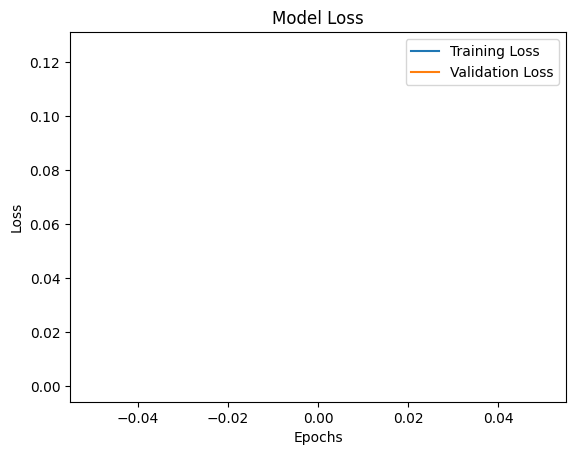

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc = 'upper right')
plt.show()

#### **7.2 <font color='yellow'>**|**</font> Accuracy of Training and Validation**

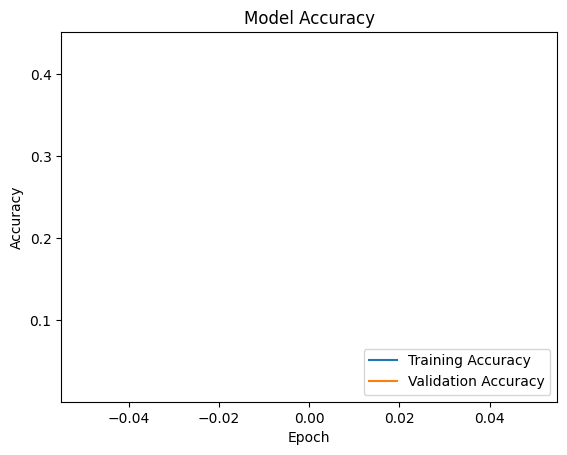

In [29]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()